In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import random
import albumentations as A
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/'YAI 봄학기 Toy Project'

/content/drive/MyDrive/YAI 봄학기 Toy Project


In [4]:
csv_train_path = "trainx2.csv"
csv_test_path = "test_append_re.csv"
csv_val_path = "val_append_re.csv"
image_path = "./images"
batch_size = 128 # CUDA out of memory로 인해 256 ~> 128 수정
epochs = 100 # 여러번 시도 했는데 50 근처에서 자꾸 런타임이 초기화 되네요...
learning_rate = 1e-3
seed = 42

In [5]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [6]:
class AllDataset(Dataset):
    def __init__(self, csv_path, image_path, image_transform=transforms.Compose([transforms.ToTensor()])):
        super(AllDataset).__init__()
        csv = pd.read_csv(csv_path)
        csv_np = csv.to_numpy()
        
        self.image_transform = image_transform
        self.ids = list(map(str, csv['Id']))
        self.image_path = image_path
        
        for i in [1, 3, 4, 5, 6, 7, 8]:
            wordset = {word: idx for idx, word in enumerate(np.unique(csv_np[:,i]))}
            for row in range(len(csv_np)):
                csv_np[row][i] = wordset[csv_np[row][i]]
        self.ints = torch.from_numpy(np.array(csv_np[:,[1,3,4,5,6,7,8]], dtype="int"))
        self.floats = torch.from_numpy(np.array(csv_np[:,[2,9,10,11]], dtype="float")).float()
        self.target = torch.from_numpy(np.array(csv_np[:,[12]], dtype="float")).float()
    
    
    def __getitem__(self,idx):
        return self.image_transform(Image.open(self.image_path+'/'+self.ids[idx]+'.jpg')), self.ints[idx],self.floats[idx], self.target[idx]
    
    
    def __len__(self):
        return len(self.ints)

In [7]:
image_transform = transforms.Compose([transforms.ToTensor()
                                     ])
train_dataset = AllDataset(csv_train_path, image_path, image_transform)
test_dataset = AllDataset(csv_test_path, image_path, image_transform)
val_dataset = AllDataset(csv_val_path, image_path, image_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle = True)


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=False)
        self.resnet18.fc = nn.Sequential(nn.Linear(512, 4096),
                                         nn.BatchNorm1d(4096),
                                         nn.ReLU(),
                                         nn.Dropout()
                                        )
        self.resenet18 = self.resnet18.to(device)
        
        self.emb1 = torch.nn.Embedding(8, 20)
        self.emb2 = torch.nn.Embedding(11, 20)
        self.emb3 = torch.nn.Embedding(20, 20)
        self.emb4 = torch.nn.Embedding(4, 20)
        self.emb5 = torch.nn.Embedding(4, 20)
        self.emb6 = torch.nn.Embedding(4, 20)
        self.emb7 = torch.nn.Embedding(7, 20)
        self.act = nn.ReLU()
        self.fc = nn.Linear(4, 80)
        self.csvbn = nn.BatchNorm1d(80)
        self.csvfc1 = nn.Linear(220, 8192)
        self.csvfc2 = nn.Linear(8192, 8192)
        self.csvfc3 = nn.Linear(8192, 4096)
        self.csvbn1 = nn.BatchNorm1d(8192)
        self.csvbn2 = nn.BatchNorm1d(8192)
        self.csvbn3 = nn.BatchNorm1d(4096)
        
        self.fc1 = nn.Linear(8192, 4096)
        self.fc2 = nn.Linear(4096, 1)
        self.bn1 = nn.BatchNorm1d(4096)
        self.dropout = nn.Dropout()
    
    def forward(self, image, x, y):
        image = self.resnet18(image)
        
        x1 = self.emb1(x[:,0])
        x2 = self.emb2(x[:,1])
        x3 = self.emb3(x[:,2])
        x4 = self.emb4(x[:,3])
        x5 = self.emb5(x[:,4])
        x6 = self.emb6(x[:,5])
        x7 = self.emb7(x[:,6])
        y = self.csvbn(self.fc(y))
        x = torch.cat((x1, x2, x3, x4, x5, x6, x7, y), dim=1)
        
        x = self.dropout(self.act(self.csvbn1(self.csvfc1(x))))
        x = self.dropout(self.act(self.csvbn2(self.csvfc2(x))))
        x = self.dropout(self.act(self.csvbn3(self.csvfc3(x))))
        x = torch.cat((x, image), dim=1)
        
        x = self.dropout(self.act(self.bn1(self.fc1(x))))
        return self.fc2(x)

In [9]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [10]:
model = Net().to(device)

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

gc.collect()
torch.cuda.empty_cache()

In [11]:
for epoch in range(epochs):
    model.train()
    criterion.train()
    
    avg_loss = 0

    for Img, X1, X2, Y in train_loader:
        Img = Img.to(device)
        X1 = X1.to(device)
        X2 = X2.to(device)
        Y = Y.to(device)

        model.zero_grad()
        prediction = model(Img, X1, X2)
        loss = torch.sqrt(criterion(prediction, Y)).to(device)
        loss.backward()
        optimizer.step()
        avg_loss += loss / len(train_loader)
    print(f'[Epoch: {epoch+1:>2}] Average loss: {avg_loss:.4f}, ', end='')
    
    model.eval()
    criterion.eval()
    with torch.no_grad():
        val_avg_loss = 0.
        for Image_val, X1_val, X2_val, Y_val in val_loader:
            Image_val = Image_val.to(device)
            X1_val = X1_val.to(device)
            X2_val = X2_val.to(device)
            Y_val = Y_val.to(device)
            val_prediction = model(Image_val, X1_val, X2_val)
            val_loss = torch.sqrt(criterion(val_prediction, Y_val)).to(device)
            val_avg_loss += val_loss / len(val_loader)
        
        print(f"val_loss: {val_avg_loss:.4f}")

[Epoch:  1] Average loss: 25325.6738, val_loss: 18224.7793
[Epoch:  2] Average loss: 25132.4766, val_loss: 17987.3750
[Epoch:  3] Average loss: 24958.2422, val_loss: 17853.5645
[Epoch:  4] Average loss: 24693.9199, val_loss: 17882.4688
[Epoch:  5] Average loss: 24387.7363, val_loss: 17792.1855
[Epoch:  6] Average loss: 24078.3281, val_loss: 17405.4297
[Epoch:  7] Average loss: 23661.9727, val_loss: 17172.3574
[Epoch:  8] Average loss: 23248.5293, val_loss: 16621.1152
[Epoch:  9] Average loss: 22759.1387, val_loss: 16703.2871
[Epoch: 10] Average loss: 22256.9629, val_loss: 16157.1133
[Epoch: 11] Average loss: 21677.3184, val_loss: 15830.0938
[Epoch: 12] Average loss: 21072.8984, val_loss: 15435.3184
[Epoch: 13] Average loss: 20395.2773, val_loss: 14862.9619
[Epoch: 14] Average loss: 19709.9219, val_loss: 14798.8516
[Epoch: 15] Average loss: 18964.3008, val_loss: 13723.4473
[Epoch: 16] Average loss: 18188.8301, val_loss: 13339.5986
[Epoch: 17] Average loss: 17358.3828, val_loss: 13591.39

In [12]:
PATH = './'
Name = 'model_stfsplit_crwaling_x2.pt'
torch.save(model.state_dict(), PATH+Name)

In [13]:
RMSEs = []
accuracys = []

In [14]:
model.eval()
criterion.eval()
ss_tot = 0
ss_res = 0
test_loader = DataLoader(test_dataset, batch_size=1, shuffle = True)
pred = []
label = []
with torch.no_grad():
    for Image_test, X1_test, X2_test, Y_test in test_loader:
        if Y_test < 20000:
            continue
        Image_test =Image_test.to(device)
        X1_test = X1_test.to(device)
        X2_test = X2_test.to(device)
        Y_test = Y_test.to(device)
        prediction = model(Image_test, X1_test, X2_test)
        print(f"결과값:{Y_test.item():.2f}$, 예측값 :{prediction.item():.2f}$")
        pred.append(prediction)
        label.append(Y_test)
    pred = torch.tensor(pred)
    label = torch.tensor(label)
    mean = torch.mean(label)
    ss_tot += torch.sum((label - mean) ** 2)
    ss_res += torch.sum((label - pred) ** 2)
    
    accuracy = 1 - ss_res/ss_tot
    RMSE = (torch.sum((label - pred)**2) / len(pred.numpy()))**(1/2)
    accuracys.append(accuracy)
    RMSEs.append(RMSE)
    print(f"Accuracy: {accuracy*100:.2f}   RMSE : {RMSE:.2f}",)

결과값:20860.01$, 예측값 :9918.90$
결과값:27122.16$, 예측값 :15179.05$
결과값:20173.51$, 예측값 :13676.49$
결과값:45075.72$, 예측값 :51412.91$
결과값:27205.50$, 예측값 :31926.10$
결과값:24901.69$, 예측값 :18437.65$
결과값:32303.92$, 예측값 :26080.50$
결과값:23382.75$, 예측값 :37432.28$
결과값:49707.29$, 예측값 :48308.25$
결과값:21292.03$, 예측값 :9038.40$
결과값:25803.49$, 예측값 :27854.13$
결과값:22980.98$, 예측값 :8129.32$
결과값:25892.41$, 예측값 :38110.07$
결과값:31337.89$, 예측값 :49348.59$
결과값:28350.11$, 예측값 :27299.23$
결과값:61111.33$, 예측값 :25575.19$
결과값:36709.39$, 예측값 :19007.53$
결과값:25659.50$, 예측값 :17541.71$
결과값:35719.12$, 예측값 :47277.25$
결과값:24027.79$, 예측값 :25048.17$
결과값:36689.98$, 예측값 :44993.75$
결과값:34224.76$, 예측값 :23313.71$
결과값:41077.42$, 예측값 :20134.96$
결과값:49176.27$, 예측값 :16919.13$
결과값:27634.20$, 예측값 :32285.80$
결과값:30493.40$, 예측값 :26961.61$
결과값:56131.02$, 예측값 :50080.76$
결과값:27329.64$, 예측값 :9075.16$
결과값:51524.24$, 예측값 :65097.44$
결과값:40273.43$, 예측값 :39658.61$
결과값:33084.11$, 예측값 :41275.10$
결과값:59670.09$, 예측값 :25952.24$
결과값:24964.93$, 예측값 :27695.17$
결과값:32632.75$,

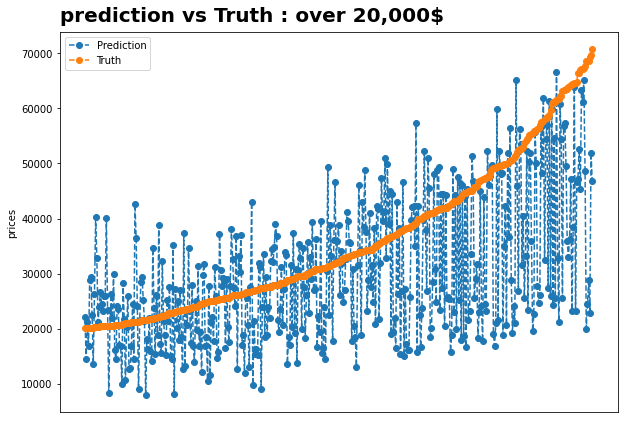

In [15]:
prediction = pd.DataFrame({'pred': pred.numpy().tolist(),
                          'label': label.numpy().tolist()})
prediction = prediction.sort_values(by=['label'])
prediction = prediction.reset_index(drop=True)
fig, ax = plt.subplots(1, 1,figsize = (10, 7))

ax.plot(prediction.index, prediction['pred'],label='Prediction',        
        marker = 'o',
        linestyle = '--',)
ax.plot(prediction.index, prediction['label'], label = 'Truth',
        marker = 'o',
        linestyle = '--',)
ax.set_title(f"prediction vs Truth : over 20,000$", loc='left', fontsize=20, va= 'bottom', fontweight='semibold')
ax.legend()
plt.ylabel('prices')
plt.xticks([])
ax.set_xticks([])
plt.show()

In [16]:
model.eval()
criterion.eval()
ss_tot = 0
ss_res = 0
test_loader = DataLoader(test_dataset, batch_size=1, shuffle = True)
pred = []
label = []
with torch.no_grad():
    for Image_test, X1_test, X2_test, Y_test in test_loader:
        if Y_test < 15000:
            continue
        Image_test =Image_test.to(device)
        X1_test = X1_test.to(device)
        X2_test = X2_test.to(device)
        Y_test = Y_test.to(device)
        prediction = model(Image_test, X1_test, X2_test)
        print(f"결과값:{Y_test.item():.2f}$, 예측값 :{prediction.item():.2f}$")
        pred.append(prediction)
        label.append(Y_test)
    pred = torch.tensor(pred)
    label = torch.tensor(label)
    mean = torch.mean(label)
    ss_tot += torch.sum((label - mean) ** 2)
    ss_res += torch.sum((label - pred) ** 2)
    
    accuracy = 1 - ss_res/ss_tot
    RMSE = (torch.sum((label - pred)**2) / len(pred.numpy()))**(1/2)
    print(f"Accuracy: {accuracy*100:.2f}   RMSE : {RMSE:.2f}", )

결과값:20860.01$, 예측값 :9918.90$
결과값:49075.34$, 예측값 :49788.47$
결과값:23700.97$, 예측값 :23195.67$
결과값:50439.17$, 예측값 :56468.07$
결과값:21931.09$, 예측값 :23694.73$
결과값:33296.64$, 예측값 :35527.46$
결과값:23382.75$, 예측값 :37432.28$
결과값:24389.96$, 예측값 :16901.23$
결과값:20965.96$, 예측값 :10734.27$
결과값:37691.55$, 예측값 :15429.92$
결과값:43148.04$, 예측값 :22965.41$
결과값:51362.03$, 예측값 :21094.57$
결과값:49931.34$, 예측값 :42354.17$
결과값:35416.68$, 예측값 :21785.25$
결과값:68617.96$, 예측값 :24586.12$
결과값:69297.88$, 예측값 :22805.11$
결과값:42250.88$, 예측값 :25742.03$
결과값:31817.76$, 예측값 :36058.43$
결과값:20633.28$, 예측값 :14544.98$
결과값:61082.46$, 예측값 :54576.81$
결과값:27122.16$, 예측값 :15179.05$
결과값:23814.90$, 예측값 :17460.71$
결과값:46774.57$, 예측값 :22972.81$
결과값:21269.26$, 예측값 :42633.95$
결과값:39272.56$, 예측값 :57315.09$
결과값:26351.57$, 예측값 :18871.65$
결과값:69759.86$, 예측값 :51983.24$
결과값:31533.98$, 예측값 :33170.91$
결과값:32800.56$, 예측값 :24883.28$
결과값:41077.42$, 예측값 :20134.96$
결과값:26083.82$, 예측값 :24110.98$
결과값:44832.26$, 예측값 :45284.14$
결과값:20068.89$, 예측값 :22211.98$
결과값:21823.8

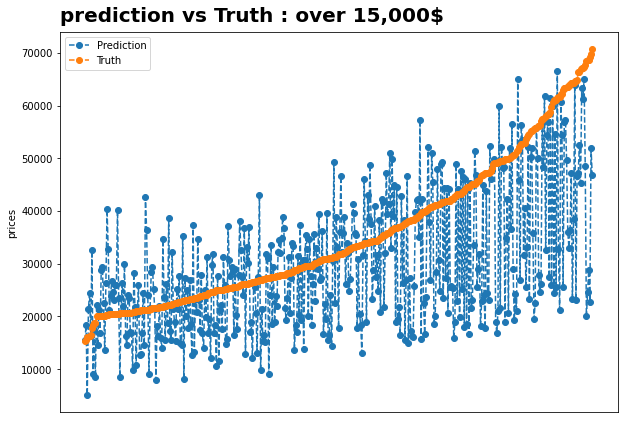

In [17]:
prediction = pd.DataFrame({'pred': pred.numpy().tolist(),
                          'label': label.numpy().tolist()})
prediction = prediction.sort_values(by=['label'])
prediction = prediction.reset_index(drop=True)
fig, ax = plt.subplots(1, 1,figsize = (10, 7))

ax.plot(prediction.index, prediction['pred'],label='Prediction',        
        marker = 'o',
        linestyle = '--',)
ax.plot(prediction.index, prediction['label'], label = 'Truth',
        marker = 'o',
        linestyle = '--',)
ax.set_title(f"prediction vs Truth : over 15,000$", loc='left', fontsize=20, va= 'bottom', fontweight='semibold')
ax.legend()
plt.ylabel('prices')
plt.xticks([])
ax.set_xticks([])
plt.show()

In [18]:
model.eval()
criterion.eval()
ss_tot = 0
ss_res = 0
test_loader = DataLoader(test_dataset, batch_size=1, shuffle = True)
pred = []
label = []
with torch.no_grad():
    for Image_test, X1_test, X2_test, Y_test in test_loader:
        if Y_test < 10000:
            continue
        Image_test =Image_test.to(device)
        X1_test = X1_test.to(device)
        X2_test = X2_test.to(device)
        Y_test = Y_test.to(device)
        prediction = model(Image_test, X1_test, X2_test)
        print(f"결과값:{Y_test.item():.2f}$, 예측값 :{prediction.item():.2f}$")
        pred.append(prediction)
        label.append(Y_test)
    pred = torch.tensor(pred)
    label = torch.tensor(label)
    mean = torch.mean(label)
    ss_tot += torch.sum((label - mean) ** 2)
    ss_res += torch.sum((label - pred) ** 2)
    
    accuracy = 1 - ss_res/ss_tot
    RMSE = (torch.sum((label - pred)**2) / len(pred.numpy()))**(1/2)
    print(f"Accuracy: {accuracy*100:.2f}   RMSE : {RMSE:.2f}", )

결과값:49397.98$, 예측값 :59893.57$
결과값:52699.97$, 예측값 :53543.36$
결과값:13500.16$, 예측값 :9131.17$
결과값:13490.76$, 예측값 :10382.18$
결과값:45801.04$, 예측값 :28981.04$
결과값:41613.86$, 예측값 :48888.43$
결과값:29404.60$, 예측값 :13763.76$
결과값:43216.40$, 예측값 :47590.49$
결과값:55114.43$, 예측값 :50202.70$
결과값:42250.88$, 예측값 :25742.03$
결과값:67290.13$, 예측값 :65050.97$
결과값:29117.12$, 예측값 :37448.14$
결과값:35410.46$, 예측값 :41724.82$
결과값:27946.11$, 예측값 :36762.39$
결과값:35880.23$, 예측값 :41269.85$
결과값:15476.93$, 예측값 :18426.56$
결과값:38599.92$, 예측값 :39814.63$
결과값:37753.27$, 예측값 :26831.69$
결과값:37297.65$, 예측값 :26337.65$
결과값:21648.12$, 예측값 :16306.90$
결과값:37187.48$, 예측값 :42951.25$
결과값:20280.75$, 예측값 :26303.01$
결과값:22399.73$, 예측값 :21405.35$
결과값:21735.81$, 예측값 :15998.37$
결과값:41719.09$, 예측값 :44369.23$
결과값:25892.41$, 예측값 :38110.07$
결과값:13336.86$, 예측값 :13549.64$
결과값:33397.60$, 예측값 :30871.31$
결과값:21373.06$, 예측값 :28487.28$
결과값:16480.38$, 예측값 :16308.63$
결과값:31780.32$, 예측값 :17726.05$
결과값:21089.69$, 예측값 :25948.77$
결과값:27909.02$, 예측값 :34910.33$
결과값:23972.1

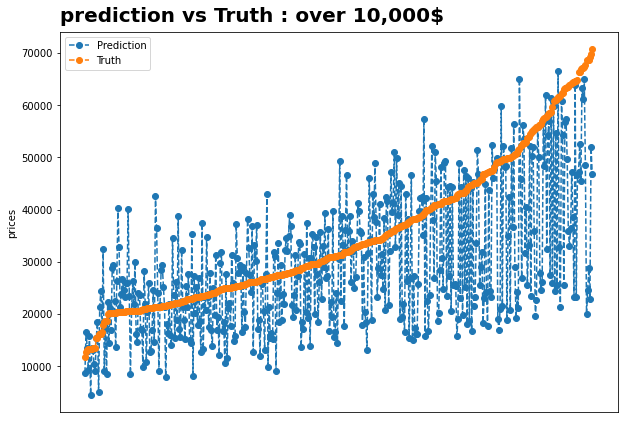

In [19]:
prediction = pd.DataFrame({'pred': pred.numpy().tolist(),
                          'label': label.numpy().tolist()})
prediction = prediction.sort_values(by=['label'])
prediction = prediction.reset_index(drop=True)
fig, ax = plt.subplots(1, 1,figsize = (10, 7))

ax.plot(prediction.index, prediction['pred'],label='Prediction',        
        marker = 'o',
        linestyle = '--',)
ax.plot(prediction.index, prediction['label'], label = 'Truth',
        marker = 'o',
        linestyle = '--',)
ax.set_title(f"prediction vs Truth : over 10,000$", loc='left', fontsize=20, va= 'bottom', fontweight='semibold')
ax.legend()
plt.ylabel('prices')
plt.xticks([])
ax.set_xticks([])
plt.show()

In [20]:
model.eval()
criterion.eval()
ss_tot = 0
ss_res = 0
test_loader = DataLoader(test_dataset, batch_size=1, shuffle = True)
pred = []
label = []
with torch.no_grad():
    for Image_test, X1_test, X2_test, Y_test in test_loader:
        Image_test =Image_test.to(device)
        X1_test = X1_test.to(device)
        X2_test = X2_test.to(device)
        Y_test = Y_test.to(device)
        prediction = model(Image_test, X1_test, X2_test)
        print(f"결과값:{Y_test.item():.2f}$, 예측값 :{prediction.item():.2f}$")
        pred.append(prediction)
        label.append(Y_test)
    pred = torch.tensor(pred)
    label = torch.tensor(label)
    mean = torch.mean(label)
    ss_tot += torch.sum((label - mean) ** 2)
    ss_res += torch.sum((label - pred) ** 2)
    
    accuracy = 1 - ss_res/ss_tot
    RMSE = (torch.sum((label - pred)**2) / len(pred.numpy()))**(1/2)
    print(f"Accuracy: {accuracy*100:.2f}   RMSE : {RMSE:.2f}", )

결과값:2066.92$, 예측값 :1486.49$
결과값:1973.23$, 예측값 :1021.71$
결과값:1105.87$, 예측값 :783.10$
결과값:34232.64$, 예측값 :41043.93$
결과값:3173.68$, 예측값 :3618.15$
결과값:5991.94$, 예측값 :1575.18$
결과값:1212.63$, 예측값 :855.86$
결과값:1447.35$, 예측값 :841.05$
결과값:4011.70$, 예측값 :3148.41$
결과값:1985.94$, 예측값 :1578.17$
결과값:37691.55$, 예측값 :15429.92$
결과값:33248.83$, 예측값 :35819.71$
결과값:753.77$, 예측값 :858.77$
결과값:1347.34$, 예측값 :827.36$
결과값:926.68$, 예측값 :550.99$
결과값:1993.12$, 예측값 :1469.27$
결과값:2508.64$, 예측값 :2342.57$
결과값:33859.16$, 예측값 :46030.53$
결과값:2817.63$, 예측값 :3789.08$
결과값:2213.67$, 예측값 :2487.79$
결과값:55834.65$, 예측값 :22640.60$
결과값:1538.85$, 예측값 :1064.71$
결과값:1091.99$, 예측값 :703.72$
결과값:1624.24$, 예측값 :1415.79$
결과값:808.48$, 예측값 :990.34$
결과값:1173.20$, 예측값 :843.97$
결과값:31342.97$, 예측값 :22489.01$
결과값:24578.10$, 예측값 :12156.96$
결과값:1281.80$, 예측값 :691.98$
결과값:1463.57$, 예측값 :1358.22$
결과값:49964.93$, 예측값 :20691.99$
결과값:2044.65$, 예측값 :2425.25$
결과값:1427.29$, 예측값 :1187.32$
결과값:2059.52$, 예측값 :1808.24$
결과값:2100.82$, 예측값 :1028.36$
결과값:2987.55$, 예측값

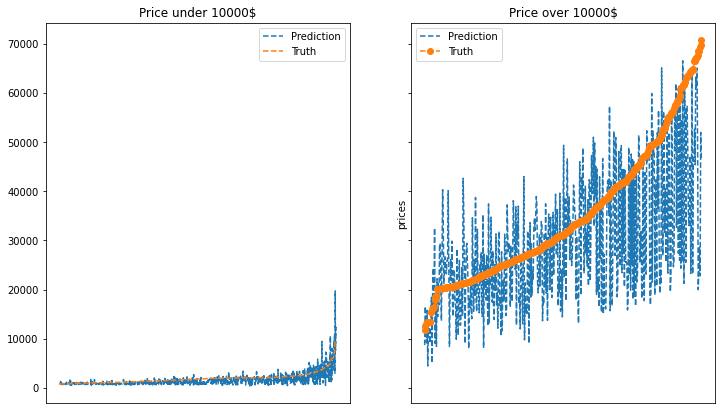

In [21]:
prediction = pd.DataFrame({'pred': pred.numpy().tolist(),
                          'label': label.numpy().tolist()})
prediction = prediction.sort_values(by=['label'])
prediction = prediction.reset_index(drop=True)

fig, axes = plt.subplots(1, 2,figsize = (12, 7), sharey = True)

prediction1 = prediction[prediction['label'] < 10000]
axes[0].plot(prediction1.index, prediction1['pred'],label='Prediction',        
        linestyle = '--',)
axes[0].plot(prediction1.index, prediction1['label'], label = 'Truth',
        linestyle = '--',)
axes[0].set_xticks([])
axes[0].legend()
axes[0].set_title("Price under 10000$")
prediction2 = prediction[prediction['label'] > 10000]
axes[1].plot(prediction2.index, prediction2['pred'],label='Prediction',        
        linestyle = '--',)
axes[1].plot(prediction2.index, prediction2['label'], label = 'Truth',
        marker = 'o',
        linestyle = '--',)
axes[1].set_xticks([])
axes[1].legend()
axes[1].set_title("Price over 10000$")
plt.ylabel('prices')
plt.show()